In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
import os
import time


from scikeras.wrappers import KerasClassifier
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV

2022-06-26 13:50:37.714405: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape((-1, 784))
X_test = X_test.reshape((-1, 784))
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

In [4]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
y_train.shape

(55000,)

In [6]:
def build_model(input_shape=784, output_shape=10, n_hidden=3, n_neurons=200, learning_rate=1e-3, compile=True):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(output_shape, activation="softmax"))
                  
    if compile:
        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
            metrics=["accuracy"],
        )
    
    return model

In [7]:
def get_tensorboard_cb():
    base_dir = os.path.join(os.curdir, ".tflogs")
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return keras.callbacks.TensorBoard(run_dir)    

In [8]:
model = build_model(learning_rate=1e-5)

2022-06-26 13:50:39.751892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 13:50:40.170339: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-26 13:50:40.170375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 10)                2010      
                                                                 
Total params: 239,410
Trainable params: 239,410
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers

In [11]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

In [12]:
n_steps = 500

checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_digits_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = get_tensorboard_cb()
learning_rate_callback = LearningRateCallback(1e-5, 1e1, n_steps)

history = model.fit(
    X_train,
    y_train,
    epochs=1,
    steps_per_epoch=n_steps,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb, learning_rate_callback],
)

 38/500 [=>............................] - ETA: 1s - loss: 2.3313 - accuracy: 0.0976

2022-06-26 13:50:41.250787: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


500/500 [==============================] - 4s 7ms/step - loss: nan - accuracy: 0.2685 - val_loss: nan - val_accuracy: 0.1018


approximate best learning rate: 0.046979554494222


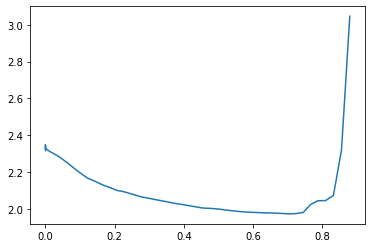

In [13]:
learning_rates = np.array(learning_rate_callback.learning_rates)
losses = np.array(learning_rate_callback.losses)

idx = losses < 10
learning_rates_clean = learning_rates[idx]
losses_clean = losses[idx]

plt.plot(learning_rates_clean, losses_clean)
best_idx = np.argmin(losses_clean)
best_learning_rate = learning_rates[best_idx] / 15.
print(f"approximate best learning rate: {best_learning_rate}")

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
model = build_model(learning_rate=best_learning_rate)

model_file = "mnist_digits_model.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
tensorboard_cb = get_tensorboard_cb()

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3495 - accuracy: 0.8974 - val_loss: 0.1562 - val_accuracy: 0.9524
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1351 - accuracy: 0.9590 - val_loss: 0.1160 - val_accuracy: 0.9620
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0917 - accuracy: 0.9729 - val_loss: 0.0935 - val_accuracy: 0.9728
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0700 - accuracy: 0.9782 - val_loss: 0.0768 - val_accuracy: 0.9780
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.0699 - val_accuracy: 0.9774
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.0740 - val_accuracy: 0.9782
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0341 - accuracy: 0.9897 - val_loss: 0.0887 - val_ac

In [16]:
model = keras.models.load_model(model_file)
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0653 - accuracy: 0.9802


[0.06530974060297012, 0.9801999926567078]

### Bayesian Optimization Using skopt BayesSearchCV

In [21]:
# def build_model(input_shape, output_shape, n_hidden=3, n_neurons=200, learning_rate=1e-3, compile=True):
# loss="sparse_categorical_crossentropy",
# optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
# metrics=["accuracy"],

# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

clf = KerasClassifier(
    model=build_model,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD,
    epochs=5,
    n_hidden=3,
    n_neurons=200,
    learning_rate=1e-3,
    compile=False,
)

opt = BayesSearchCV(
    clf,
    {
        "n_hidden": (1, 5),
        "n_neurons": (20, 300),
        "optimizer__learning_rate": (1e-3, 1., "uniform")
    },
    n_iter=32,
    cv=3,
    n_jobs=16,
)

opt.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])

2022-06-26 17:02:56.685113: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:02:56.685559: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:02:56.688383: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:02:57.978762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:02:59.576675: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:02:59.588642: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:02:59.624107: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 1.3339 - accuracy: 0.5241
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7871 - accuracy: 0.2938
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.1289
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.1264
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.4150 - accuracy: 0.1880
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3084 - accuracy: 0.1028
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: nan - accuracy: 0.0987
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3085 - accuracy: 0.1029
Epoch 5/5
1250/

2022-06-26 17:03:29.312622: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:03:29.312624: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:03:29.320108: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:03:30.613822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:03:32.229067: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:03:32.231791: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:03:32.275710: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 1.7987 - accuracy: 0.2731
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 2.2945 - accuracy: 0.1150
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5427 - accuracy: 0.4290
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9823 - accuracy: 0.1789
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3085 - accuracy: 0.1053
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9539 - accuracy: 0.2783
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9775 - accuracy: 0.1850
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9967 - accuracy: 0.1869
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8799 - accuracy: 0.1956
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3086 - accuracy: 0.1035


2022-06-26 17:04:00.295118: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:00.295118: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:00.296385: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:01.591602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:04:03.158834: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:04:03.220434: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:04:03.236988: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.4035 - accuracy: 0.8776
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.4492 - accuracy: 0.8659
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.6435 - accuracy: 0.8100
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1991 - accuracy: 0.9426
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2581 - accuracy: 0.9294
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1467 - accuracy: 0.9577
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1606 - accuracy: 0.9546
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1197 - accuracy: 0.9652
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1365 - accuracy: 0.9620
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1749 - accuracy: 0.9513


2022-06-26 17:04:30.624859: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:30.624866: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:30.624868: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:31.920089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:04:33.525633: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:04:33.527335: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:04:33.553104: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.2585 - accuracy: 0.9207
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2479 - accuracy: 0.9248
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2544 - accuracy: 0.9214
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1087 - accuracy: 0.9677
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1056 - accuracy: 0.9671
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1069 - accuracy: 0.9668
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0728 - accuracy: 0.9771
Epoch 4/5
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0710 - accuracy: 0.9777
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0524 - accuracy: 0.9831
Epoch 5/5
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0505

2022-06-26 17:04:59.811264: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:59.811267: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:04:59.811267: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:05:01.117677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:05:02.657183: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:05:02.679825: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:05:02.796116: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.2773 - accuracy: 0.9143
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2697 - accuracy: 0.9148
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2724 - accuracy: 0.9153
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1135 - accuracy: 0.9653
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1157 - accuracy: 0.9646
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1120 - accuracy: 0.9645
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0835 - accuracy: 0.9736
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0807 - accuracy: 0.9749
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0817 - accuracy: 0.9741
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0607 - accuracy: 0.9803


2022-06-26 17:05:28.981080: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/5
Epoch 1/5
 351/1250 [=======>......................] - ETA: 3s - loss: 2.0641 - accuracy: 0.2052

2022-06-26 17:05:30.324858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 464/1250 [==========>...................] - ETA: 2s - loss: 2.0022 - accuracy: 0.2195

2022-06-26 17:05:30.789004: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-26 17:05:30.789039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6341 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


   1/1250 [..............................] - ETA: 17:47 - loss: 2.3743 - accuracy: 0.0000e+00

2022-06-26 17:05:31.898272: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 1.6089 - accuracy: 0.3644
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3158 - accuracy: 0.105551328.0000 - accuracy: 0.13
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9508 - accuracy: 0.195288224.0000 - accuracy: 0.13
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1396337871647052715868223141052416.0000 - accuracy: 0.1148
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3072 - accuracy: 0.1056
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2207 - accuracy: 0.1298
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3069 - accuracy: 0.1028
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3068 - accuracy: 0.1055
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3065 - accuracy: 0.1049
Epoch 5/5
1250

2022-06-26 17:13:15.882406: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:13:15.882410: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/5
 437/1250 [=========>....................] - ETA: 2s - loss: 0.6161 - accuracy: 0.8157

2022-06-26 17:13:17.254637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 17:13:17.258622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 637/1250 [==============>...............] - ETA: 1s - loss: 0.5187 - accuracy: 0.8446

2022-06-26 17:13:17.768619: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-26 17:13:17.768662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18972 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6
2022-06-26 17:13:17.785717: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-26 17:13:17.785751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18962 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


  36/1250 [..............................] - ETA: 3s - loss: 1.6283 - accuracy: 0.4887   

2022-06-26 17:13:18.788552: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:13:18.844853: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 4s 3ms/step - loss: 0.3871 - accuracy: 0.8850
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.3321 - accuracy: 0.8992
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1796 - accuracy: 0.9463
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1612 - accuracy: 0.9520
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1463 - accuracy: 0.9574
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1277 - accuracy: 0.9620
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1224 - accuracy: 0.9631
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1030 - accuracy: 0.9690
Epoch 5/5
625/625 [==============================] - 2s 3ms/step


2022-06-26 17:13:45.844074: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:13:45.900051: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:13:45.900051: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:13:47.136568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:13:48.653409: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:13:48.683561: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:13:48.719172: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.2569 - accuracy: 0.9215
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2581 - accuracy: 0.9205
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1071 - accuracy: 0.9671
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1097 - accuracy: 0.9676
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1046 - accuracy: 0.9678
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0723 - accuracy: 0.9778
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0730 - accuracy: 0.9777
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0706 - accuracy: 0.9784
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0519 - accuracy: 0.9836
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0510 - accuracy: 0.9835


2022-06-26 17:14:16.258793: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:14:16.258793: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:14:16.278213: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:14:17.553980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:14:19.106619: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:14:19.144814: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:14:19.171450: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.4520 - accuracy: 0.8650
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.4517 - accuracy: 0.8671
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1859 - accuracy: 0.9471
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1824 - accuracy: 0.9477
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1667 - accuracy: 0.9513
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1489 - accuracy: 0.9558
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1563 - accuracy: 0.9547
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1264 - accuracy: 0.9633
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1304 - accuracy: 0.9625
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1231 - accuracy: 0.9648


2022-06-26 17:14:48.007305: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:14:48.007317: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:14:48.007314: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:14:49.308471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:14:50.868171: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:14:50.872053: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:14:50.896187: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.3133 - accuracy: 0.9047
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.3438 - accuracy: 0.8941
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.3046 - accuracy: 0.9069
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1419 - accuracy: 0.9577
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1428 - accuracy: 0.9574
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1085 - accuracy: 0.9677
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1289 - accuracy: 0.9618
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1115 - accuracy: 0.9672
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0855 - accuracy: 0.9737
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1063 - accuracy: 0.9682


2022-06-26 17:15:18.258178: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:15:18.258176: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:15:18.258178: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-26 17:15:19.552599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized w

Epoch 1/5
Epoch 1/5
Epoch 1/5


2022-06-26 17:15:21.141819: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:15:21.172969: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 17:15:21.188206: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.2638 - accuracy: 0.9165
Epoch 2/5
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2565 - accuracy: 0.9198
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1099 - accuracy: 0.9662
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1143 - accuracy: 0.9653
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1083 - accuracy: 0.9665
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0784 - accuracy: 0.9757
Epoch 4/5
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0783 - accuracy: 0.9752
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0586 - accuracy: 0.9808
Epoch 5/5
625/625 [==============================] - 2s 2ms/step
Epoch 1/5
Epoch 1/5
   1/1250 [..............................] - ETA: 3:23 - loss: 2.2824 - accuracy: 0.2500

2022-06-26 17:15:48.301726: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


 390/1250 [========>.....................] - ETA: 2s - loss: 1.3578 - accuracy: 0.5337

2022-06-26 17:15:49.646804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 521/1250 [===========>..................] - ETA: 2s - loss: 1.2235 - accuracy: 0.5855

2022-06-26 17:15:50.129616: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-26 17:15:50.129666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


  31/1250 [..............................] - ETA: 4s - loss: 8.3991 - accuracy: 0.1280 

2022-06-26 17:15:51.263364: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 4s 3ms/step - loss: 1.2410 - accuracy: 0.5663
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8395 - accuracy: 0.7364
Epoch 2/5
1250/1250 [==============================] - 6s 4ms/step - loss: 2.4592 - accuracy: 0.1045
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7464 - accuracy: 0.7433
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3076 - accuracy: 0.1037
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5915 - accuracy: 0.8037
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3944 - accuracy: 0.8986
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2869 - accuracy: 0.1123
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6272 - accuracy: 0.8055
Epoch 5/5
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3261 - accuracy: 0.9164


2022-06-26 17:16:19.351734: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/5
Epoch 1/5
 308/1250 [======>.......................] - ETA: 3s - loss: 2.1248 - accuracy: 0.2575

2022-06-26 17:16:20.689012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 414/1250 [========>.....................] - ETA: 3s - loss: 2.0254 - accuracy: 0.2786

2022-06-26 17:16:21.153581: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-26 17:16:21.153623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


 734/1250 [================>.............] - ETA: 2s - loss: 1.7150 - accuracy: 0.3831 

2022-06-26 17:16:22.289221: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.8090 - accuracy: 0.7433
Epoch 2/5
1250/1250 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.0997
Epoch 2/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2439 - accuracy: 0.9358
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3465 - accuracy: 0.9121
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: nan - accuracy: 0.0987
Epoch 3/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1743 - accuracy: 0.9536
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: nan - accuracy: 0.7534
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: nan - accuracy: 0.0987
Epoch 4/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1533 - accuracy: 0.9598
Epoch 5/5
1250/1250 [==============================] - 6s 5ms/step - loss: nan - accuracy: 0.0987
Epoch 5/5
625/6

BayesSearchCV(cv=3,
              estimator=KerasClassifier(compile=False, epochs=5, learning_rate=0.001, loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function build_model at 0x7f5cd93bb910>, n_hidden=3, n_neurons=200, optimizer=<class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>),
              n_iter=32, n_jobs=16,
              search_spaces={'n_hidden': (1, 5), 'n_neurons': (20, 300),
                             'optimizer__learning_rate': (0.001, 1.0,
                                                          'uniform')})

In [22]:
print(opt.best_params_)
print(opt.best_score_)

OrderedDict([('n_hidden', 2), ('n_neurons', 262), ('optimizer__learning_rate', 0.09760613032623651)])
0.9742666666666667


In [26]:
opt.best_estimator_.fit(X_train_full, y_train_full)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 115729621843968.0000 - accuracy: 0.1087
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 2.3019 - accuracy: 0.1111
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 2.3020 - accuracy: 0.1111
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 2.3019 - accuracy: 0.1116
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 2.3019 - accuracy: 0.1110


KerasClassifier(
	model=<function build_model at 0x7f5cd93bb910>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>
	loss=sparse_categorical_crossentropy
	metrics=['accuracy']
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=5
	n_hidden=2
	n_neurons=262
	learning_rate=0.001
	compile=False
	optimizer__learning_rate=0.09760613032623651
	class_weight=None
)